Import Dependencies

In [2]:
from ctypes import c_int

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
from scipy import stats
import matplotlib.colors as colors

Load  data into a  DataFrame

In [3]:
# Load the data
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]

# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory
del mb_raw_data
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20464\1776410603.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


Train Model

In [4]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[["Charge", 'Mass', 'Length']]
y = mb_clean_frame['CCS_z']
# Define the number of folds
k = 4

Perform k-fold cross validation

In [5]:
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)
# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Create a linear regression model
    model = LinearRegression(n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_test_orig = y_test * ccs_std + ccs_mean

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test_orig, y_pred_orig)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X, y)

# Print the average MSE score
print("Average Mean Squared Error:", np.mean(mse_scores))
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 1.0168659707066008e-72
Average Median Relative Error: 0.030916242928585365
Average R^2 Score: 0.9836873562407769
Time elapsed: 0.50 seconds


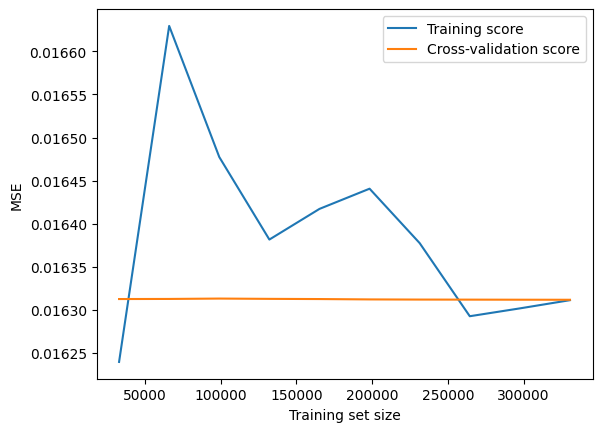

In [6]:
from sklearn.model_selection import learning_curve

# Define the sizes of the training sets to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(n_jobs=-1),
    X,
    y,
    train_sizes=train_sizes,
    cv=k,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate the average training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()


Feature: 0, Score: 1.74357
Feature: 1, Score: -0.00058
Feature: 2, Score: -0.00822


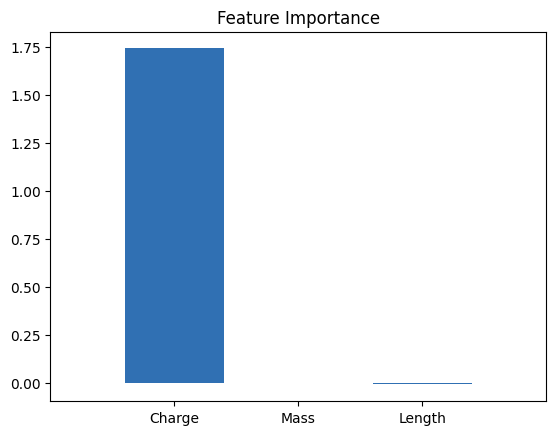

In [7]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
plt.title("Feature Importance")
features = X.columns
plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
plt.xlim([-1, X.shape[1]])
plt.show()

Save the model

In [8]:
# Predict the CCS of the peptides in the data frame
mb_clean_frame['Predicted CCS'] = final_model.predict(X)

# Reverse the z-score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS'] * ccs_std + ccs_mean


Spearman's Correlation Coefficient: 0.9943846753132166


C:\Program Files\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Length', ylabel='Percent Error'>

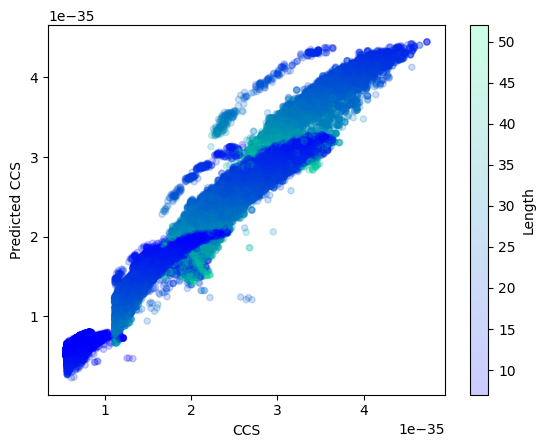

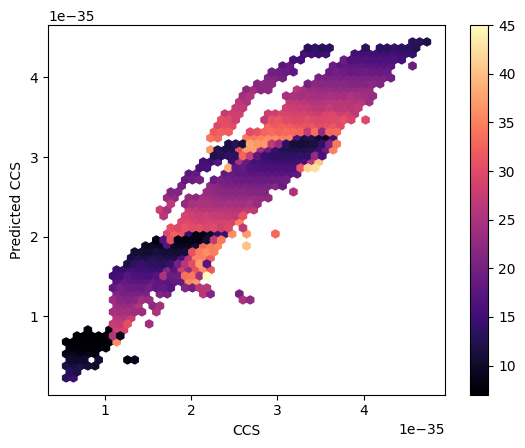

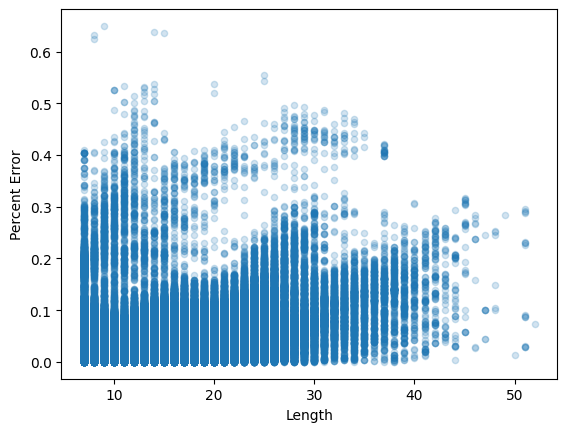

In [9]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)



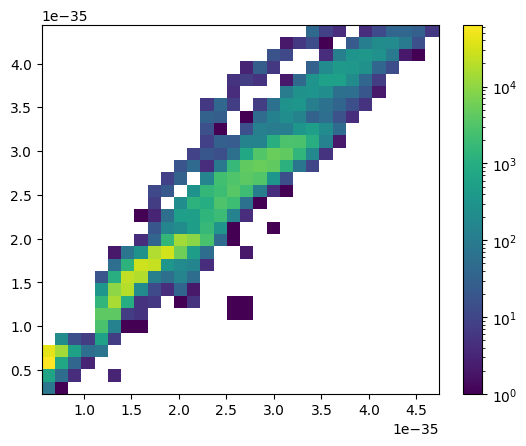

In [10]:
ccs_data = mb_clean_frame["CCS"].to_numpy()
predicted_ccs_data = mb_clean_frame["Predicted CCS"].to_numpy()

x = mb_clean_frame["CCS"]
y = mb_clean_frame["Predicted CCS"]

plt.hist2d(x, y, bins=[30,30],norm=colors.LogNorm())
plt.colorbar()
plt.show()



Save the model to a file

In [11]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))